In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp
import math
from networkx import linalg
import pandas as pd
import csv

%matplotlib inline

In [1]:
import subprocess
import os

cmd = subprocess.Popen('pwd', stdout=subprocess.PIPE)
cmd_out, cmd_err = cmd.communicate()
local_path = os.fsdecode(cmd_out).strip()

Description of the data: Consumer Airfare Report:Top 1000 Contiguous State City-Pair Markets.
   Source of the data: Bureau of Transportation statistics (US Bureau of Transportation) 
   Downloaded from the following website: 
   https://www.transportation.gov/policy/aviation-policy/domestic-airline-consumer-airfare-report

In [4]:
df = pd.read_csv(local_path + "/data/Consumer_Airfare_Report__Table_1_-_Top_1_000_Contiguous_State_City-Pair_Markets.csv",\
                 low_memory = False)
#df = pd.read_csv("Consumer_Airfare_Report__Table_6_-_Contiguous_State_City-Pair_Markets_That_Average_At_Least_10_Passengers_Per_Day.csv",\
#                 low_memory = False)

df.drop(columns = ['Geocoded_City1','Geocoded_City2','table_1_flag'], inplace = True)

Importing and extracting relevant data for getting location of airports in terms of longitudes and latitudes.


In [9]:
airports = pd.read_csv(local_path + "/data/list_of_airports_usa.csv")

airports[airports['type'] == 'large_airport'].head(5)

airports.drop(columns = ['id','type','continent','iso_country','scheduled_service',\
                         'gps_code','iata_code','home_link','wikipedia_link','keywords',\
                         'score','last_updated'],inplace = True)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated
0,3632,KLAX,large_airport,Los Angeles International Airport,33.942501,-118.407997,125.0,NaN,US,US-CA,Los Angeles,1,KLAX,LAX,LAX,http://www.iflylax.com/,http://en.wikipedia.org/wiki/Los_Angeles_Inter...,NaN,1335475,2010-01-23T11:27:55+00:00
1,3622,KJFK,large_airport,John F Kennedy International Airport,40.639801,-73.778900,13.0,NaN,US,US-NY,New York,1,KJFK,JFK,JFK,http://www.panynj.gov/CommutingTravel/airports...,http://en.wikipedia.org/wiki/John_F._Kennedy_I...,"Manhattan, New York City, NYC, Idlewild",1052075,2010-01-23T11:27:54+00:00
2,3754,KORD,large_airport,Chicago O'Hare International Airport,41.978600,-87.904800,672.0,NaN,US,US-IL,Chicago,1,KORD,ORD,ORD,http://www.flychicago.com/ohare/en/home/Pages/...,http://en.wikipedia.org/wiki/O'Hare_Internatio...,"CHI, Orchard Place",1503175,2014-08-19T18:55:27+00:00
3,3384,KATL,large_airport,Hartsfield Jackson Atlanta International Airport,33.636700,-84.428101,1026.0,NaN,US,US-GA,Atlanta,1,KATL,ATL,ATL,http://www.atlanta-airport.com/,http://en.wikipedia.org/wiki/Hartsfield-Jackso...,NaN,2002475,2008-06-13T14:30:04+00:00
4,3878,KSFO,large_airport,San Francisco International Airport,37.618999,-122.375000,13.0,NaN,US,US-CA,San Francisco,1,KSFO,SFO,SFO,http://www.flysfo.com/,http://en.wikipedia.org/wiki/San_Francisco_Int...,"QSF, QBA",1112475,2008-06-13T14:30:04+00:00


The total number of flights of different airline carriers for the year 2018.

In [18]:
for carrier in df['carrier_lg'].unique():
    df1 = pd.concat([df[df['carrier_lg'] == carrier], df[df['carrier_low'] == carrier]])
    df2 = df1[df1['Year'] == 2018]
    print(carrier, len(df2))
    
#print(df['carrier_lg'].unique())

FL 0
DL 1027
NW 0
AA 1090
CO 0
US 0
WN 3062
UA 702
G4 409
HP 0
JI 0
AS 444
NK 274
YX 0
W9 0
B6 404
TW 0
QQ 0
DH 0
F9 530
TZ 0
W7 0
NJ 0
SY 55
SX 0
ZA 0
WV 0
J7 0
N7 0
U5 0
QX 0
KW 0
RU 0
ZW 0
YV 0
PN 0
T3 0
RP 0
KP 0
XJ 0
9N 0
VX 5
A7 0


We pick Southwest airlines (WN) for analysis. By changing carrier name suitably, we can carry out the same analysis for any other documented airline company.

In [19]:

carrier_name = 'WN'
df1 = pd.concat([df[df['carrier_lg'] == carrier_name], df[df['carrier_low'] == carrier_name]])
df2 = df1[df1['Year'] == 2018]

df2.head(5)

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low
89240,2018,2,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",580,557,220.45,WN,0.5485,208.64,WN,0.5485,208.64
89241,2018,2,30140,30325,"Albuquerque, NM","Denver, CO",349,517,136.09,WN,0.5480,137.86,WN,0.5480,137.86
89243,2018,2,30140,30423,"Albuquerque, NM","Austin, TX",619,220,171.98,WN,0.5922,196.04,G4,0.1366,72.86
89244,2018,2,30140,30466,"Albuquerque, NM","Phoenix, AZ",328,710,153.30,WN,0.8019,149.82,WN,0.8019,149.82
89246,2018,2,30140,30721,"Albuquerque, NM","Boston, MA (Metropolitan Area)",1974,287,264.47,WN,0.4489,245.19,WN,0.4489,245.19


Creating a dictionary for the list of cities mapped to the city market ids. Calculation of avarage fares, distances, passengers per day for all the flight routes in the network.

In [20]:
nodes = list(df2['citymarketid_1'].unique()) + list(df2['citymarketid_2'].unique())
node_labels = {}
for k in range(len(nodes)):
    node_labels.update({k:nodes[k]})
    
citylist = {}
city1 = list(df2.city1)
city2 = list(df2.city2)
city1mid = list(df2.citymarketid_1)
city2mid = list(df2.citymarketid_2)
for entry in nodes:
    try:
        index = city1mid.index(entry)
        citylist.update({entry:city1[index]})
    except ValueError as ve:
        index = city2mid.index(entry)
        citylist.update({entry:city2[index]})
        
average_fare = []
dist = []
fliers = []
miles = list(df2.nsmiles)
fares = list(df2.fare)
passengers = list(df2.passengers)
for airport1 in list(citylist.keys()):
    indices1 = np.argwhere(city1mid == airport1).flatten()
    for airport2 in list(citylist.keys()):
        indices2 = np.argwhere(city2mid == airport2).flatten()
        indices = np.intersect1d(indices1, indices2)
        s = 0.0
        f = 0.0
        p = 0.0
        k = 0
        l = 0
        m = 0
        if len(indices) != 0:
            for item in indices:
                if fares[item] != 0.0:
                    f = f + fares[item]
                    k = k + 1
                if miles[item] != 0.0:
                    s = s + miles[item]
                    l = l + 1
                if passengers[item] != 0.0:
                    p = p + passengers[item]
                    m = m + 1
                
            s = s/l
            f = f/k
            p = p/m
        
            average_fare.append([airport1,airport2,f])
            dist.append([airport1,airport2,s])
            fliers.append([airport1,airport2,p])

longitudes = {33367:-90.5065224,34794:-113.508987}
latitudes = {33367:41.4486452,34794:37.030792}
altitudes ={}
for city in citylist:
    try:
        t = citylist[city].split(',')[0]
        latitudes.update({city:list(airports[airports['municipality'] == t.split('/')[0]].latitude_deg)[0]})
        longitudes.update({city:list(airports[airports['municipality'] == t.split('/')[0]].longitude_deg)[0]})
        altitudes.update({city:list(airports[airports['municipality'] == t.split('/')[0]].elevation_ft)[0]})
    except IndexError as ie:
        t = citylist[city].split(',')[0]
        if t == 'St. Louis':
            latitudes.update({city:list(airports[airports['municipality'] == 'Saint Louis'].latitude_deg)[0]})
            longitudes.update({city:list(airports[airports['municipality'] == 'Saint Louis'].longitude_deg)[0]})
            altitudes.update({city:list(airports[airports['municipality'] == 'Saint Louis'].elevation_ft)[0]})
        elif t == 'New York City':
            latitudes.update({city:list(airports[airports['municipality'] == 'New York'].latitude_deg)[0]})
            longitudes.update({city:list(airports[airports['municipality'] == 'New York'].longitude_deg)[0]})
            altitudes.update({city:list(airports[airports['municipality'] == 'New York'].elevation_ft)[0]})

Function to compute distance between locations based on longitudes and latitudes

In [21]:
def distance(lat1,lat2, lon1, lon2):
    R = 6371e3 

    phi1 = lat1 * math.pi/180
    # phi, lambda in radians
    phi2 = lat2 * math.pi/180
    delta_phi = (lat2-lat1) * math.pi/180
    delta_lambda = (lon2-lon1) * math.pi/180
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1-a));
    d = R * c

    return int(d/1000.0)

Airport and flight networks are defined as weighted graphs

In [22]:
G = nx.Graph()
for n in range(len(average_fare)):
    G.add_edge(average_fare[n][0],average_fare[n][1], weight = average_fare[n][2])
    
H = nx.Graph()
for n in range(len(average_fare)):
    try:
        H.add_edge(dist[n][0], dist[n][1], weight = distance(latitudes[dist[n][0]],latitudes[dist[n][1]],longitudes[dist[n][0]],longitudes[dist[n][1]]))
    except KeyError as ke:
        print('the location info is missing for one of the nodes: (%5.0d,%5.0d)' %(dist[n][0],dist[n][1]))
        
        
K = nx.Graph()
for n in range(len(fliers)):
    K.add_edge(fliers[n][0], fliers[n][1], weight = fliers[n][2])
    
L = nx.Graph()
for n in range(len(average_fare)):
    L.add_edge(average_fare[n][0],average_fare[n][1])

In [23]:
print('Number of airports in the network: %3.d' %len(list(H.nodes())))
print('Number of flight connections in the network: %3.d' %len(list(H.edges())))

Number of airports in the network:  72
Number of flight connections in the network: 721


Function to compute average ticker fare

In [24]:
def fare(subpaths):
    fare = 0
    for edge in subpaths:
        for price in average_fare:
            if (edge[0] == price[0]) and (edge[1] == price[1]):
                fare = fare + price[2]
            elif (edge[1] == price[0]) and (edge[0] == price[1]):
                fare = fare + price[2]
            
    return fare

Shortest paths obtained by using graph networks with different weights such as distance, average fare,
number of passengers. When the assigned weights are distances, we get shortest flights between two
locations. When the assigned weights are average ticket prices, we get cheapest flights between two
locations.

In [29]:
nodesg = list(G.nodes)
nodesh = list(H.nodes)
pathsg = nx.shortest_path(G,weight='weight')
pathsh = nx.shortest_path(H,weight='weight')
mismatches = []
#for j in range(len(nodesg)):
#    for k in range(len(pathsg)):
#        if len(pathsg[nodesg[j]][nodesg[k]]) != len(pathsh[nodesg[j]][nodesh[k]]):
#            mismatches.append([nodesg[j], nodesg[k], nodesh[k]])

for j in range(len(nodesh)):
    for k in range(len(pathsh)):
        if len(pathsg[nodesh[j]][nodesh[k]]) != len(pathsh[nodesh[j]][nodesh[k]]):
            mismatches.append([nodesh[j], nodesh[k]])
            
source_airport = mismatches[5][0]
destination_airport = mismatches[5][1]
print('Number of edges traversed in the network: %1.0f' \
      %nx.shortest_path_length(L,source_airport,destination_airport))
print('Corresponding trajectory is the following:') 
print([citylist[entry] for entry in nx.shortest_path(L,source_airport,destination_airport)])
            
source_airport = mismatches[5][0]
destination_airport = mismatches[5][1]
print('The total kilometers travelled: %5.2f' \
      % nx.shortest_path_length(H,source_airport,destination_airport,weight='weight'))
print('Corresponding trajectory is the following:') 
print([citylist[entry] for entry in nx.shortest_path(H,source_airport,destination_airport,weight='weight')])

source_airport = mismatches[5][0]
destination_airport = mismatches[5][1]
print('Average total fare is: $%4.2f' \
      %nx.shortest_path_length(G,source_airport,destination_airport,weight='weight'))
print('Corresponding trajectory is the following:') 
print([citylist[entry] for entry in nx.shortest_path(G,source_airport,destination_airport,weight='weight')])

Number of edges traversed in the network: 2
Corresponding trajectory is the following:
['Denver, CO', 'Dallas/Fort Worth, TX', 'Buffalo, NY']
The total kilometers travelled: 2184.00
Corresponding trajectory is the following:
['Denver, CO', 'Omaha, NE', 'Chicago, IL', 'Buffalo, NY']
Average total fare is: $348.84
Corresponding trajectory is the following:
['Denver, CO', 'Orlando, FL', 'Buffalo, NY']


In [30]:
path = nx.shortest_path(L,source_airport,destination_airport,weight='weight')
gpath = nx.shortest_path(G,source_airport,destination_airport,weight='weight')
hpath = nx.shortest_path(H,source_airport,destination_airport,weight='weight')
subpaths = [[path[k+1], path[k]] for k in range(len(path)-1)]
gsubpaths = [[gpath[k+1], gpath[k]] for k in range(len(gpath)-1)]
hsubpaths = [[hpath[k+1], hpath[k]] for k in range(len(hpath)-1)]
print('Total distance travelled for the cheapest path (in kilometers): %5.2f' \
      %sum([distance(latitudes[edge[0]],latitudes[edge[1]],longitudes[edge[0]],longitudes[edge[1]]) for edge in gsubpaths]))
print('The total fare for the cheapest path: $%4.2f' %fare(gsubpaths))
print('Total distance travelled for the shortest path (in kilometers): %5.2f' \
      %sum([distance(latitudes[edge[0]],latitudes[edge[1]],longitudes[edge[0]],longitudes[edge[1]]) for edge in hsubpaths]))
print('The total fare for the shortest path: $%4.2f' %fare(hsubpaths))
print('Total distance travelled for the shortest path in the unweighted network (in kilometers): %5.2f' \
      %sum([distance(latitudes[edge[0]],latitudes[edge[1]],longitudes[edge[0]],longitudes[edge[1]]) for edge in subpaths]))
print('The total fare for the shortest path in the unweighted network: $%4.2f' %fare(subpaths))

Total distance travelled for the cheapest path (in kilometers): 4116.00
The total fare for the cheapest path: $348.84
Total distance travelled for the shortest path (in kilometers): 2184.00
The total fare for the shortest path: $507.16
Total distance travelled for the shortest path in the unweighted network (in kilometers): 2986.00
The total fare for the shortest path in the unweighted network: $413.68


In the above lines, note that the average ticker fare is lowest for the shortest path that was obtained from a weighted graph with average ticker fare as the edge weights. Also, the distance covered by the path of cheapest fare is almost double the distance covered by taking the route of shortest duration (and distance travelled). Vice versa, for the flight route of shortest duration, the average ticket fare is higher among all three routes. This indicates that, time (along with the cost in terms of dollars) plays a major in the total utility of a flight itinerary.

Here is an image illustrating the connectivity of flights to and from Washington DC:


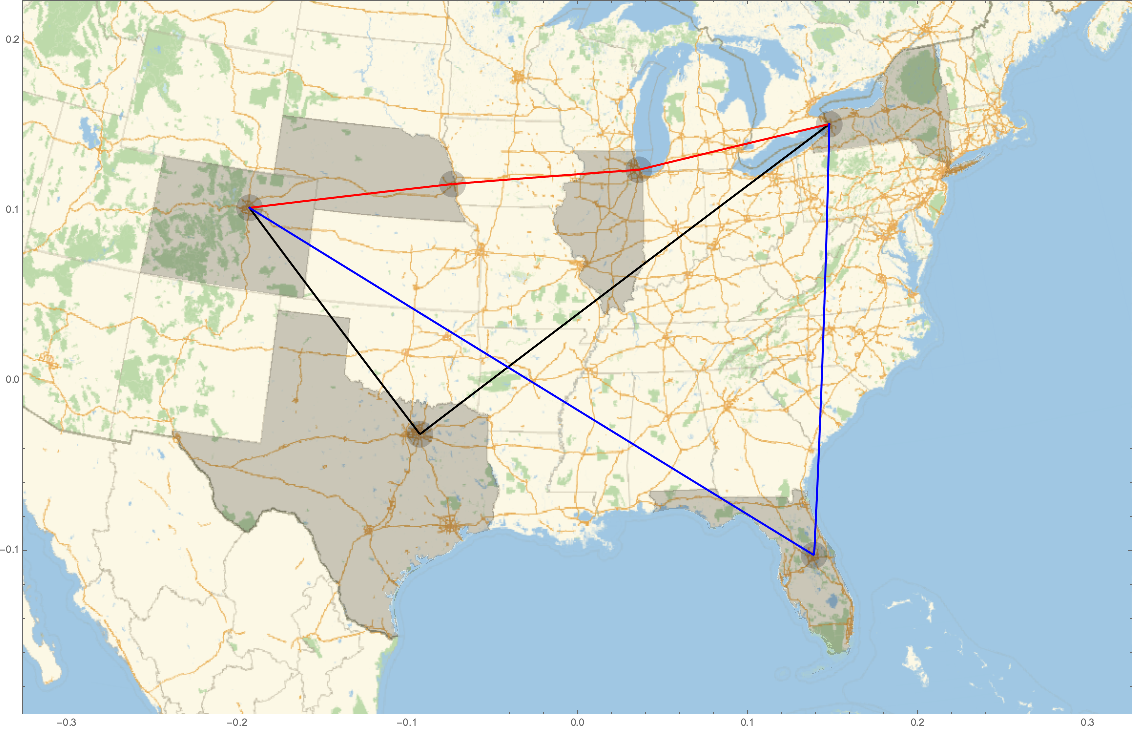

In [31]:
from IPython.display import Image
print('Here is an image illustrating the connectivity of flights to and from Washington DC:')
Image(filename = local_path + "/viz/shortest_paths.png", width=1000, height=500)

The data on flight connections, distances between pairs of cities and average ticket fares are cached in data folder.

In [33]:
s = local_path + "/data/WN_2018_fares.csv"
with open(s, 'w+') as fh:
    csvwriter = csv.writer(fh)
    csvwriter.writerow(['Origin city','Destination city','Average fare (in $)'])
    for t in list(G.edges.data()):
        csvwriter.writerow([citylist[t[0]],citylist[t[1]],round(t[2]['weight'])])
        
s = local_path + "/data/WN_2018_nsmiles.csv"
with open(s, 'w+') as fh:
    csvwriter = csv.writer(fh)
    csvwriter.writerow(['Origin city','Destination city','Distance (in kilometers)'])
    for t in list(H.edges.data()):
        csvwriter.writerow([citylist[t[0]],citylist[t[1]],t[2]['weight']]) 
        
s = local_path + "/data/WN_2018.csv"
with open(s, 'w+') as fh:
    csvwriter = csv.writer(fh)
    csvwriter.writerow(['Origin city','Destination city'])
    for t in list(L.edges.data()):
        csvwriter.writerow([citylist[t[0]],citylist[t[1]]]) 

Degree centrality, node centrality and edge centrality measures. Nodes and edges with maximum values of
   centrality measures correpond important locations such as busiest or depot locations for nodes, which is
   illustrated below for Southwest airline network.

In [35]:
node_importance_one = nx.degree_centrality(L)
node_importance_two = nx.betweenness_centrality(L)
edge_importance = nx.edge_betweenness_centrality(L)
node_importance_two_g = nx.betweenness_centrality(G,weight='weight')
edge_importance_g = nx.edge_betweenness_centrality(G,weight='weight')
node_importance_two_h = nx.betweenness_centrality(H,weight='weight')
edge_importance_h = nx.edge_betweenness_centrality(H,weight='weight')

Busiest airport in the network that we consider is Washington DC with 57 connections.

In [36]:
degree_centrality_keys = list(node_importance_one.keys())
degree_centrality_values = list(node_importance_one.values())
print('With %2.0f connections' %max([item[1] for item in list(nx.degree(L))]), \
      citylist[degree_centrality_keys[degree_centrality_values.index(max(list(node_importance_one.values())))]], \
      'has maximum degree')

With 57 connections Washington, DC (Metropolitan Area) has maximum degree


In [45]:
print('Flight connections to and from Washngton DC {airports}'.format(airports = \
                                                                      [citylist[item] for item in list(nx.neighbors(L,30852))]))

Flight connections to and from Washngton DC ['Albuquerque, NM', 'Dallas/Fort Worth, TX', 'Pittsburgh, PA', 'Albany, NY', 'Austin, TX', 'Phoenix, AZ', 'Hartford, CT', 'Birmingham, AL', 'El Paso, TX', 'Cleveland, OH (Metropolitan Area)', 'Nashville, TN', 'Boise, ID', 'Boston, MA (Metropolitan Area)', 'Buffalo, NY', 'Chicago, IL', 'Columbus, OH', 'St. Louis, MO', 'Jacksonville, FL', 'Houston, TX', 'Orlando, FL', 'Panama City, FL', 'Fort Myers, FL', 'Grand Rapids, MI', 'Las Vegas, NV', 'Indianapolis, IN', 'San Francisco, CA (Metropolitan Area)', 'Miami, FL (Metropolitan Area)', 'Little Rock, AR', 'Louisville, KY', 'Sacramento, CA', 'Tampa, FL (Metropolitan Area)', 'Kansas City, MO', 'San Antonio, TX', 'Memphis, TN', 'Omaha, NE', 'Milwaukee, WI', 'New Orleans, LA', 'San Diego, CA', 'Norfolk, VA (Metropolitan Area)', 'Oklahoma City, OK', 'Portland, OR', 'Raleigh/Durham, NC', 'Reno, NV', 'Rochester, NY', 'Des Moines, IA', 'West Palm Beach/Palm Beach, FL', 'Atlanta, GA (Metropolitan Area)', 'T

Here is an image illustrating the connectivity of flights to and from Washington DC:


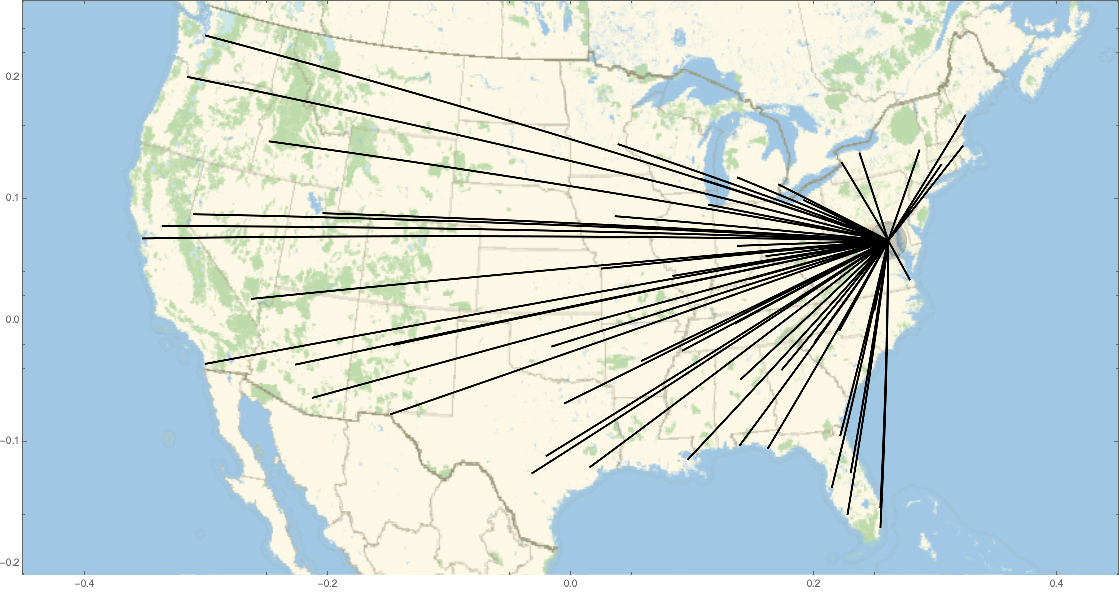

In [40]:
from IPython.display import Image
print('Here is an image illustrating the connectivity of flights to and from Washington DC:')
Image(filename = local_path + "/viz/washington_dc_all_connections.png", width=1000, height=500)

The depot airport loaction for Southwest airlines is in Dallas/Fort Worth, Texas, where the headquarters
   of the airline company is situated.

In [41]:
betweenness_centrality_h_keys = list(node_importance_two_h.keys())
betweenness_centrality_h_values = list(node_importance_two_h.values())
print(citylist[betweenness_centrality_h_keys[betweenness_centrality_h_values.index(max(list(node_importance_two_h.values())))]])

Dallas/Fort Worth, TX


In [42]:
betweenness_centrality_g_keys = list(node_importance_two_g.keys())
betweenness_centrality_g_values = list(node_importance_two_g.values())
print(citylist[betweenness_centrality_g_keys[betweenness_centrality_g_values.index(max(list(node_importance_two_g.values())))]])

Dallas/Fort Worth, TX


In [43]:
betweenness_centrality_keys = list(node_importance_two.keys())
betweenness_centrality_values = list(node_importance_two.values())
print(citylist[betweenness_centrality_keys[betweenness_centrality_values.index(max(list(node_importance_two.values())))]])

Dallas/Fort Worth, TX


The maximum value of edge centrality occurs for the flight path between Dallas/Fort Worth and Corpus Christi.
   Along with Dallas, TX being the location of headquarters (HQ) of Southwest airlines, it turns out they are
   the only all-main-line airline (meaning major airline) at Corpus Christi, TX. Most likely reason for this
   is that Corpus Christi, TX serves as the secondary HQ of Southwest airlines company because it is neither
   the cheapest nor the shortest flight in the network.

In [44]:
edge_centrality_g_keys = list(edge_importance_g.keys())
edge_centrality_g_values = list(edge_importance_g.values())
important_edge = edge_centrality_g_keys[edge_centrality_g_values.index(max(list(edge_importance_g.values())))]
print([citylist[item] for item in edge_centrality_g_keys[edge_centrality_g_values.index(max(list(edge_importance_g.values())))]])
print('Fare: $%3.2f' %fare([important_edge]))

['Dallas/Fort Worth, TX', 'Corpus Christi, TX']
Fare: $235.63


In [48]:
edge_centrality_h_keys = list(edge_importance_h.keys())
edge_centrality_h_values = list(edge_importance_h.values())
important_edge = edge_centrality_h_keys[edge_centrality_h_values.index(max(list(edge_importance_h.values())))]
print([citylist[item] for item in edge_centrality_h_keys[edge_centrality_h_values.index(max(list(edge_importance_h.values())))]])
print('Distance (in kilometers): %5.2f' %distance(latitudes[important_edge[0]],latitudes[important_edge[1]],longitudes[important_edge[0]],longitudes[important_edge[1]]))

['Dallas/Fort Worth, TX', 'Corpus Christi, TX']
Distance (in kilometers): 567.00


In [24]:
edge_centrality_keys = list(edge_importance.keys())
edge_centrality_values = list(edge_importance.values())
print([citylist[item] for item in edge_centrality_keys[edge_centrality_values.index(max(list(edge_importance.values())))]])

['Dallas/Fort Worth, TX', 'Corpus Christi, TX']


In [25]:
print('Cheapest flight: $%3.3f ' % min([item[2] for item in average_fare])) 
print([citylist[average_fare[[item[2] for item in average_fare].index(min([item[2] for item in average_fare]))][0]], citylist[average_fare[[item[2] for item in average_fare].index(min([item[2] for item in average_fare]))][1]]])

Cheapest flight: $106.433 
['Boise, ID', 'Spokane, WA']


In [49]:
print('Shortest flight (distance in miles): %4.2f ' % min([item[2] for item in dist])) 
print([citylist[dist[[item[2] for item in dist].index(min([item[2] for item in dist]))][0]], citylist[dist[[item[2] for item in dist].index(min([item[2] for item in dist]))][1]]])

Shortest flight (distance in miles): 148.00 
['Austin, TX', 'Houston, TX']


Distance matrix computation. In our implementation below, we use the whole network,
   but in principle we can try the spanning tree network of the network. This would
   decrease the number of possible choices by reducing the connectivity.

In [54]:
T = nx.minimum_spanning_tree(H,weight = 'weight')
distance_matrix_T = nx.floyd_warshall_numpy(T,weight = 'weight')
distance_matrix = nx.floyd_warshall_numpy(H,weight = 'weight')

In [28]:
#single_vehicle_threshold = 10000.0
#for k in range(np.shape(distance_matrix_H)[0]):
#    for j in range(np.shape(distance_matrix_H)[1]):
#        if distance_matrix_T[k][j]  == float('inf'):
#            distance_matrix_T[k][j] = single_vehicle_threshold

Simple Vehicles Routing Problem (VRP).

   This is a sample using the routing library python wrapper to solve a VRP
   problem.
   A description of the problem can be found here:
   http://en.wikipedia.org/wiki/Vehicle_routing_problem.

   Distances are in meters.
   
   The script below is originally from Google OR tools website:
   https://developers.google.com/optimization/routing/vrp
   
   I've changed the distance matrix, number of vehicles, the depot and the total distance 
   threshold according to our needs for the airport network.


In [55]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model(separation_matrix,number_of_vehicles,o):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = separation_matrix
    #data['pickups_deliveries'] = [
    #    [1, 6],
    #    [5, 10],
    #    [7, 8],
    #    [2, 0],
    #    [4, 3],
    #    [11, 15],
    #   [13, 12],
    #    [16, 14],
    #]
    data['num_vehicles'] = number_of_vehicles
    data['depot'] = o
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    #print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        #print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print('Maximum of the route distances: {}m'.format(max_route_distance))
    return max_route_distance
    
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
  # Get vehicle routes and store them in a two dimensional array whose
  # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes



def main(matrix,number_of_aircrafts,depo):
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(matrix,number_of_aircrafts,depo)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        50000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    
    # Define Transportation Requests.
    #for request in data['pickups_deliveries']:
    #    pickup_index = manager.NodeToIndex(request[0])
    #    delivery_index = manager.NodeToIndex(request[1])
    #    routing.AddPickupAndDelivery(pickup_index, delivery_index)
    #    routing.solver().Add(
    #        routing.VehicleVar(pickup_index) == routing.VehicleVar(
    #            delivery_index))
    #    routing.solver().Add(
    #        distance_dimension.CumulVar(pickup_index) <=
    #        distance_dimension.CumulVar(delivery_index))

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        max_distance = print_solution(data, manager, routing, solution)
        solution_paths = get_routes(solution, routing, manager)
    else:
        print('No solution found !')
        
    return [solution_paths, max_distance]


#if __name__ == '__main__':
#    main()

For starters I've called the fuction or subroutine of solving vehicle routing problem above to
   solve for close to optimal routes for airport network with 72 airports with depot at 
   Dallas/Fort Worth, TX. I specifically choose the solution consisting of tours of length
   two or three airports. In its current state, I am varying the number of aircrafts to arrive
   at a feasible solution. However, we can fix that number based on an estimate from the daily
   flights data of an airline company.

In [56]:
close_to_optimal_routes = []
maximum_distance_travelled = []
for k in range(5,6):
    #print('first level')
    solution1 = main(distance_matrix,k,1)
    paths1 = solution1[0]
    close_to_optimal_routes.append(solution1[0])
    maximum_distance_travelled.append(solution1[1])
    for route1 in paths1:
        if len(route1) > 4:
            n_labels = {}
            d1 = np.zeros((len(route1)-1,len(route1)-1))
            for i in range(len(route1)-1):
                for j in range(len(route1)-1):
                    d1[i,j] = d1[i,j] + distance_matrix[route1[i],route1[j]]
                    n_labels.update({i:route1[i]})
                    n_labels.update({j:route1[j]})
            
            #print('second level')
            solution2 = main(d1,4,0)
            paths2 = solution2[0]
            temp = []
            for subpath in paths2:
                temp.append([n_labels[item] for item in subpath])
                
            close_to_optimal_routes.append(temp)
            maximum_distance_travelled.append(solution2[1])
            for route2 in paths2:
                if len(route2) > 4:
                    nn_labels = {}
                    d2 = np.zeros((len(route2)-1,len(route2)-1))
                    for m in range(len(route2)-1):
                        for n in range(len(route2)-1):
                            d2[m,n] = d2[m,n] + d1[route2[m],route2[n]]
                            nn_labels.update({m:route2[m]})
                            nn_labels.update({n:route2[n]})
                    
                    #print('third level')
                    solution3 = main(d2,4,0)
                    paths3 = solution3[0]
                    temp = []
                    for subpath in paths3:
                        temp.append([n_labels[nn_labels[item]] for item in subpath])
                        
                    close_to_optimal_routes.append(temp)
                    maximum_distance_travelled.append(solution3[1])
                    for route3 in paths3:
                        if len(route3) > 4:
                            nnn_labels = {}
                            d3 = np.zeros((len(route3)-1,len(route3)-1))
                            for p in range(len(route3)-1):
                                for q in range(len(route3)-1):
                                    d3[p,q] = d3[p,q] + d2[route3[p],route3[q]]
                                    nnn_labels.update({p:route3[p]})
                                    nnn_labels.update({q:route3[q]})
                    
                            #print('fourth level')
                            solution4 = main(d3,3,0)
                            paths4 = solution4[0]
                            temp = []
                            for subpath in paths4:
                                temp.append([n_labels[nn_labels[nnn_labels[item]]] for item in subpath])
                            
                            close_to_optimal_routes.append(temp)
                            maximum_distance_travelled.append(solution4[1])
                            for route4 in paths4:
                                if len(route4) > 4:
                                    nnnn_labels = {}
                                    d4 = np.zeros((len(route4)-1,len(route4)-1))
                                    for r in range(len(route4)-1):
                                        for s in range(len(route4)-1):
                                            d4[r,s] = d4[r,s] + d3[route4[r],route4[s]]
                                            nnnn_labels.update({r:route4[r]})
                                            nnnn_labels.update({s:route4[s]})
                            
                                    #print('fifth level')
                                    solution5 = main(d4,3,0)
                                    paths5 = solution5[0]
                                    temp = []
                                    for subpath in paths5:
                                        temp.append([n_labels[nn_labels[nnn_labels[nnnn_labels[item]]]] for item in subpath])
                                    
                                    close_to_optimal_routes.append(temp)
                                    maximum_distance_travelled.append(solution5[1])
                                    
                                    for route5 in paths5:
                                        if len(route5) > 4:
                                            nnnnn_labels = {}
                                            d5 = np.zeros((len(route5)-1,len(route5)-1))
                                            for u in range(len(route5)-1):
                                                for v in range(len(route5)-1):
                                                    d5[u,v] = d5[u,v] + d4[route5[u],route5[v]]
                                                    nnnnn_labels.update({u:route5[u]})
                                                    nnnnn_labels.update({v:route5[v]})
                                                    
                                            #print('sixth level')
                                            solution = main(d5,2,0)
                                            paths = solution[0]
                                            temp = []
                                            for subpath in paths:
                                                temp.append([n_labels[nn_labels[nnn_labels[nnnn_labels[nnnnn_labels[item]]]]] for item in subpath])
                                    
                                            close_to_optimal_routes.append(temp)
                                            maximum_distance_travelled.append(solution[1])
                            

In [57]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [58]:
final_route_plan = []
for lis in flatten(close_to_optimal_routes):
    if (len(lis) < 5) and (len(lis) != 2):
        subpaths = [[nodesh[lis[k+1]], nodesh[lis[k]]] for k in range(len(lis)-1)]
        final_route_plan.append([[citylist[nodesh[item]] for item in lis], \
                                 sum([distance(latitudes[edge[0]],latitudes[edge[1]],\
                                               longitudes[edge[0]],longitudes[edge[1]]) for edge in subpaths])])
        
direct_flights = [final_route_plan[item] for item \
                  in np.where(np.array([len(route[0]) for route in final_route_plan]) == 3)[0]]
one_stop_flights = [final_route_plan[item] for item \
                    in np.where(np.array([len(route[0]) for route in final_route_plan]) == 4)[0]]

In [59]:
print('Total number of aircrafts used to cover all of the airports in the network is equal to %2.0d.'%len(final_route_plan))

Total number of aircrafts used to cover all of the airports in the network is equal to 51.


In [60]:
s = "WN_route_plan.csv"
with open(s, 'w+') as fh:
    spamwriter = csv.writer(fh)
    for flightpaths in final_route_plan:
        spamwriter.writerow(flightpaths) 

In [61]:
print('The longest tour has the travel distance (in kilometers) equal to: %5.2f' %final_route_plan[[item[1] for item in final_route_plan].index(max([item[1] for item in final_route_plan]))][1])
print('Corresponding route is: {airport}'.format(airport = final_route_plan[[item[1] for item in final_route_plan].index(max([item[1] for item in final_route_plan]))][0]))

The longest tour has the travel distance (in kilometers) equal to: 7260.00
Corresponding route is: ['Dallas/Fort Worth, TX', 'Atlanta, GA (Metropolitan Area)', 'Portland, ME', 'Dallas/Fort Worth, TX']


In [36]:
print('One-stop flights (along with the travel distances) suggested by vehicle routing problem solving algorithm are {routes}'.format(routes = one_stop_flights))

One-stop flights (along with the travel distances) suggested by vehicle routing problem solving algorithm are [[['Dallas/Fort Worth, TX', 'Atlanta, GA (Metropolitan Area)', 'Portland, ME', 'Dallas/Fort Worth, TX'], 7260], [['Dallas/Fort Worth, TX', 'Houston, TX', 'Harlingen/San Benito, TX', 'Dallas/Fort Worth, TX'], 1564], [['Dallas/Fort Worth, TX', 'Greenville/Spartanburg, SC', 'Cincinnati, OH', 'Dallas/Fort Worth, TX'], 3171], [['Dallas/Fort Worth, TX', 'Louisville, KY', 'St. Louis, MO', 'Dallas/Fort Worth, TX'], 2438], [['Dallas/Fort Worth, TX', 'Albuquerque, NM', 'Omaha, NE', 'Dallas/Fort Worth, TX'], 3041], [['Dallas/Fort Worth, TX', 'Detroit, MI', 'Chicago, IL', 'Dallas/Fort Worth, TX'], 3239], [['Dallas/Fort Worth, TX', 'Charleston, SC', 'Nashville, TN', 'Dallas/Fort Worth, TX'], 3273], [['Dallas/Fort Worth, TX', 'Los Angeles, CA (Metropolitan Area)', 'Tulsa, OK', 'Dallas/Fort Worth, TX'], 4443], [['Dallas/Fort Worth, TX', 'Spokane, WA', 'Denver, CO', 'Dallas/Fort Worth, TX'], 4

One-stop flight routes (to and from Dallas, TX) that are obtained using VRP alogorithm above


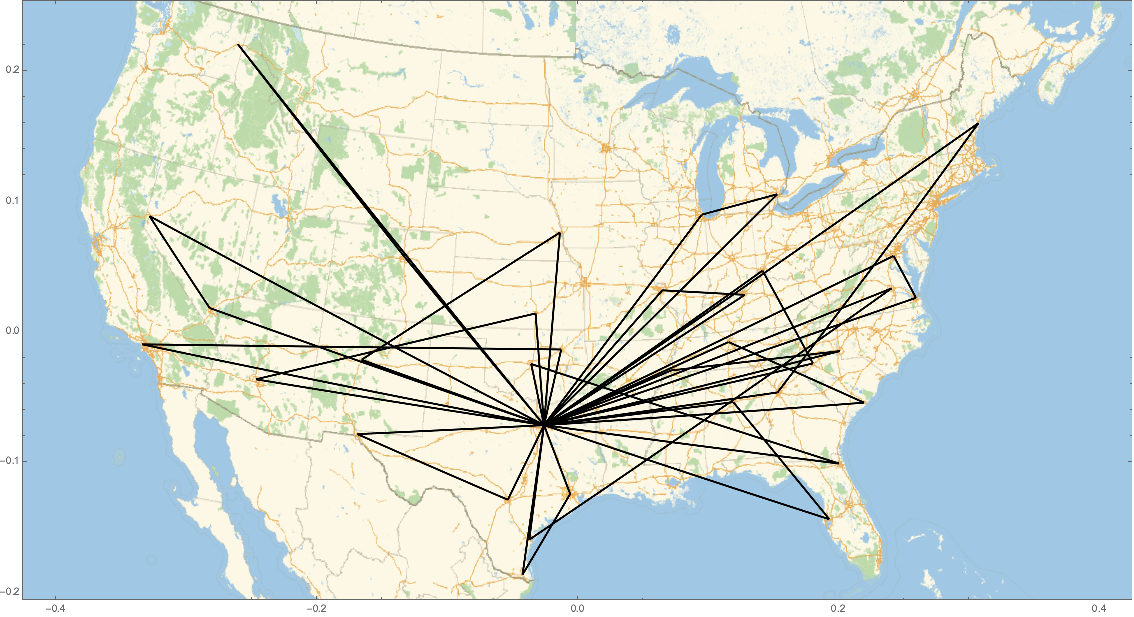

In [50]:
print('One-stop flight routes (to and from Dallas, TX) that are obtained using VRP alogorithm above')
Image(filename = local_path + "/viz/vrp_one_stop_tours.png", width=1000, height=500)

In [38]:
print('Direct flights (along with the travel distances) suggested by vehicle routing problem solving algorithm are {routes}'.format(routes = direct_flights))

Direct flights (along with the travel distances) suggested by vehicle routing problem solving algorithm are [[['Dallas/Fort Worth, TX', 'Little Rock, AR', 'Dallas/Fort Worth, TX'], 952], [['Dallas/Fort Worth, TX', 'Lubbock, TX', 'Dallas/Fort Worth, TX'], 942], [['Dallas/Fort Worth, TX', 'Panama City, FL', 'Dallas/Fort Worth, TX'], 2194], [['Dallas/Fort Worth, TX', 'Columbus, OH', 'Dallas/Fort Worth, TX'], 2954], [['Dallas/Fort Worth, TX', 'Austin, TX', 'Dallas/Fort Worth, TX'], 608], [['Dallas/Fort Worth, TX', 'New Orleans, LA', 'Dallas/Fort Worth, TX'], 1402], [['Dallas/Fort Worth, TX', 'Midland/Odessa, TX', 'Dallas/Fort Worth, TX'], 1024], [['Dallas/Fort Worth, TX', 'Amarillo, TX', 'Dallas/Fort Worth, TX'], 1038], [['Dallas/Fort Worth, TX', 'Pensacola, FL', 'Dallas/Fort Worth, TX'], 1902], [['Dallas/Fort Worth, TX', 'Albany, NY', 'Dallas/Fort Worth, TX'], 4588], [['Dallas/Fort Worth, TX', 'Rochester, NY', 'Dallas/Fort Worth, TX'], 4048], [['Dallas/Fort Worth, TX', 'Buffalo, NY', 'Dal

Direct flight routes (to and from Dallas, TX) that are obtained using VRP alogorithm above


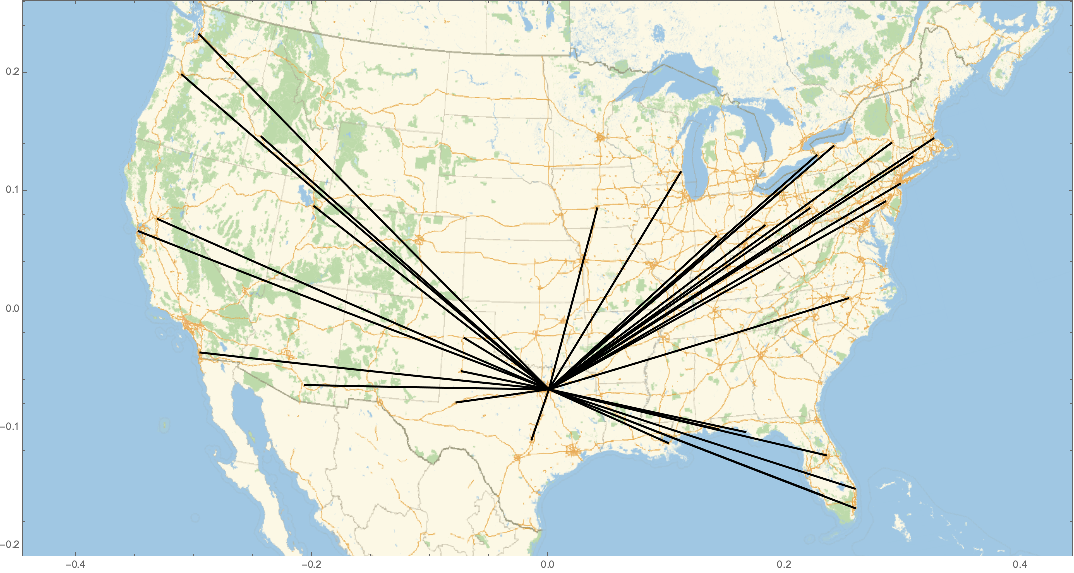

In [52]:
print('Direct flight routes (to and from Dallas, TX) that are obtained using VRP alogorithm above')
Image(filename = local_path + "/viz/vrp_direct_tours.png", width=1000, height=500)

We can do the above computation of finding close to optimal aircraft routing solutions for subnetworks
   as well. One way to choose a subnetwork is by looking at the cliques of the network i.e. fully
   connected subgraph motifs inside a network.

In [40]:
cliques_h = []
for item in nodesh:
    cliques_h.append(nx.cliques_containing_node(H,item))

M = 17    
clique_subnetwork_choices_M = []
for k in range(len(cliques_h)):
    for i in range(len(cliques_h[k])):
        for j in range(i+1,len(cliques_h[k])):
            if len(set(cliques_h[k][i] + cliques_h[k][j] )) == M:
                clique_subnetwork_choices_M.append([k,i,j])
                
hc = nx.subgraph(H,list(set(cliques_h[clique_subnetwork_choices_M[3][0]][clique_subnetwork_choices_M[3][1]] + cliques_h[clique_subnetwork_choices_M[3][0]][clique_subnetwork_choices_M[3][2]]))) 